In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hyperiax


from hyperiax.tree.topology import symmetric_topology, asymmetric_topology, read_topology, write_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree

from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology, asymmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter
from matplotlib import pyplot as plt
import jax

In [3]:
key = PRNGKey(0)

## Rate likelihood estimation - rough draft

In this notebook, we setup a rough draft of rate estimation of discerete variables 

This notebook follows work of Sergei T. (_better to say it's Felsenstein's prunning algorithm:_)

The outline of this notebook comes in; 

    1. Creating the tree

    2. Simulating discerete character from root to leafs.  (NOT implemented, i just draft some randomly)

    3. One up pass using likelihood to restimate the the rate
    
    4. Optimizer to converge for correct estimation of the rate



### 1. Creating the Tree

First, we initialize a tree. This creates a tree with a chosen topology. This topology is a "stupid" class, in the sense that it contains no data - and only serves as a representation of the data we intend to work on.

Setting `height=3` and `degree=2`, gives us a tree with 4 layers, where each node has `2` children

In [20]:
tree_str = "((A:2,B:0.3):0.1,(C:0.5,D:1):0.6);"
#topology = read_topology(tree_str)
tree = read_topology(tree_str,return_topology=False,precompute_child_gathers=True)



_ST: usually the tail of the tree (i.e. brach 7 in this case) is not used in Ln computations. I set it to 0: [0.1, 2.0, 0.3, 0.6, 0.5, 1.0, 0.0]_

    
 ┌─┴─┐
       
┌┴┐ ┌┴┐
A B C D


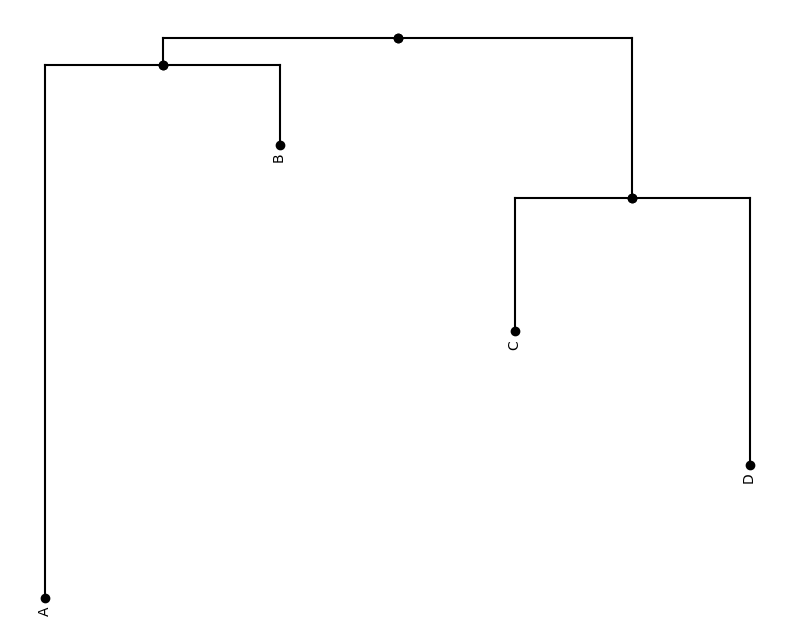

In [21]:
other_tree = False
if other_tree:
   #topology = symmetric_topology(height=2, degree=2)
   topology = asymmetric_topology(2)

   tree = HypTree(topology, precompute_child_gathers=True)


   # Propreties of the tree

   # Branch/edge length, assumed to be constant one 
   tree.add_property('edge_length', shape=(1,))

   tree.data["edge_length"]  = jnp.array([1.0] * tree.size)
   #tree.data["edge_length"]  = jnp.array([0.1, 2.0, 0.3, 0.6, 0.5, 1.0, 0.0])

   for i,node in enumerate(tree.iter_topology_bfs()):
      node.name = str(i)


# plot tree again 
plot_tree_text(tree)
plot_tree(tree,inc_names=True)


### 2. Simulating node values

Could be a markov chain, I will just draft some random values for now

I have kept the strcutre of the code how to do it proberly 

In [22]:
# Insert some correct thing here. 

#@jax.jit
#def down(noise, edge_length,parent_value, **args):
#    # Insert 
#    return {'value':value}

# Define root variable for our simulation 
#tree.data['value'] = tree.data['value'].at[0].set([0,0])

# Execute the simulation on tree
#downmodel = DownLambda(down_fn=down)
#exe = OrderedExecutor(downmodel)
#exe.down(tree)

### Fake data

In [23]:
# Draw random 0,1 in the size corresponding to the under here
# Random sampler 
# Chacters storing 
tree.add_property('value', shape=(2,))
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(jax.random.bernoulli(key, p=0.8, shape=(sum(tree.is_leaf),2)))

# Print over discerete variables 
print(tree.data['value'])
print('-----')
print(tree.data['value'][tree.is_leaf])


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
-----
[[1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### 3. Estimating the inner nodes

Here we could mask our internal nodes "value" from our downsimulation, since we would only now the leaf values. 
We keep with this format, and therefore more our leaf data to another variable


# Upward Pass Computation

We estimate the upwards probability from the leafs to the root; 

$$
p(parent)= p(t1)*p(t2) 
$$
where $p(t1)=d1*exp(Q*t1)^T$, and t1 is the branch length 

In [24]:
tree.add_property('estimated_value', shape=(2,))
leaf_data = tree.data['value'][tree.is_leaf]
tree.data['estimated_value'] = tree.data['estimated_value'].at[tree.is_leaf].set(leaf_data)

leaf_edgelength = tree.data['edge_length'][tree.is_leaf]

Now we estimate the probability in the leaf nodes, since we only have data in chacaters in the leafs, and upwards we multiply the edgelengths with probabilies (but I may have misunderstood that part)

Manual estimating here:

_ST: it should be matrix exponential jax.scipy.linalg.expm() istead of element-wise exponential_

In [25]:
# Define rate matrix, which is 2x2 as a function of input of alpha and beta
# as a function 
Q_rate_matrix = lambda alpha, beta: jnp.array([[-alpha, alpha], [beta,-beta]])

prob_estimation = lambda chacter,length : jnp.dot(chacter, jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*length))



# Define alpha and beta
alpha = 0.5
beta = 0.5



# Hyperiax implementation of up




In [29]:
def probability_function(value,child_estimated_value, child_edge_length,leaf_mask, **kwargs):
    # Do probability estimation 
    probs = jax.vmap(prob_estimation, in_axes=1)(child_estimated_value,child_edge_length)
    prods = jnp.prod(probs, axis=0)

   # Rescale the likelihood
    result = prods / jnp.sum(prods, axis=1, keepdims=True)

    # Mask padding - not the most efficiant, but problem with the reducers atm
    result = jnp.where(leaf_mask[:,None], value, result) 
    return {'estimated_value': result}


In [30]:

upmodel = UpLambda(up_fn=probability_function)
upmodelexe = OrderedExecutor(upmodel)
res = upmodelexe.up(tree)



compare result

In [31]:
print(tree.data['estimated_value'])
print('-----')
print(tree.data['estimated_value'][tree.is_leaf])

[[0.8664692  0.13353083]
 [0.76361114 0.23638888]
 [0.85846627 0.14153373]
 [1.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]
-----
[[1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [32]:
leaf_data

Array([[1., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# MS: Manual of assymteric

In [33]:
n3 = jnp.dot(leaf_data[0],jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))
n4 = jnp.dot(leaf_data[1],jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))
# conditional Ln of the ancestor 3 and 4
n3_4=n3*n4 # conditional Likelihoods 
SUM_n3_4=jnp.sum(n3_4) # Sum of likelihoods for normalization (scaling factor)
SCALED_n3_4=n3_4/SUM_n3_4 # Normalized likelihoods at the node
print(SCALED_n3_4)



root=jnp.dot(SCALED_n3_4, jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1)) * jnp.dot(leaf_data[2],jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))


SUM_root=jnp.sum(root)
SCALED_root=root/SUM_root
print(SCALED_root)



[0.6839397  0.31606027]
[0.7396746  0.26032534]


# _ST: manual computation of likelihod with rescaling_

The same as before but now we use the rescaling trick to avoid underflow.

In [34]:
#-- now we the rescaling trick

n3 = jnp.dot(leaf_data[0],jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))
n4 = jnp.dot(leaf_data[1],jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))
# conditional Ln of the ancestor 3 and 4
n3_4=n3*n4 # conditional Likelihoods 
SUM_n3_4=jnp.sum(n3_4) # Sum of likelihoods for normalization (scaling factor)
SCALED_n3_4=n3_4/SUM_n3_4 # Normalized likelihoods at the node
print(SCALED_n3_4)

n5 = jnp.dot(leaf_data[2],jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))
n6 = jnp.dot(leaf_data[3],jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))


# conditional Ln of the ancestor 5 and 6
n5_6=n5*n6

SUM_n5_6=jnp.sum(n5_6)
SCALED_n5_6=n5_6/SUM_n5_6
print(SCALED_n5_6)
# conditional Ln at the root
root=jnp.dot(SCALED_n3_4, jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1)) * jnp.dot(SCALED_n5_6, jax.scipy.linalg.expm(Q_rate_matrix(alpha,beta)*1))
SUM_root=jnp.sum(root)
SCALED_root=root/SUM_root

# Calculate the log-likelihood of the tree
root_pi=jnp.array([0.5, 0.5])
log_likelihood_sum = jnp.sum(jnp.log(jnp.array([SUM_n3_4, SUM_n5_6, SUM_root])))  # Sum of logs of scaling factors
loglik = log_likelihood_sum + jnp.log(jnp.sum(jnp.exp(jnp.log(root_pi) + jnp.log(SCALED_root))))
# this is the final Ln


[0.6839397  0.31606027]
[0.8240271  0.17597288]


## 4. Do the optimization to estimate alpha/beta

NOTE - I may not have recalled the likelihood function correctly

In [35]:
# Use JAX's BFGS optimizer from scipy.optimize

from jax.example_libraries import optimizers
from jax import grad
pi_root = [1,1]
pred_root = tree.data["estimated_value"][tree.is_root]

# Initialize optimization parameters
initial_params = jnp.array([0.5, 0.5])

# Define the negative log-likelihood function
def negative_log_likelihood(params):
    alpha, beta = params
    Q = Q_rate_matrix(alpha, beta)
    # note we do not include edge length since we are in the root
    root_probs = jnp.exp(Q)
    likelihood = jnp.sum(jnp.array(pi_root) * jnp.dot(pred_root, root_probs))

    return -jnp.log(likelihood)


# Define the optimization function
@jax.jit
def optimize_step(i, opt_state, pi_root, pred_root):
    params = get_params(opt_state)
    value, grads = jax.value_and_grad(negative_log_likelihood)(params)
    return opt_update(i, grads, opt_state), value

# Initialize the optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.01)
opt_state = opt_init(initial_params)

# Optimization loop
num_iterations = 100
for i in range(num_iterations):
    # Re-estimate the root value using upmodelexe.up
    upmodelexe.up(tree)
    pred_root = jnp.array(tree.data["estimated_value"][tree.is_root])
    
    opt_state, value = optimize_step(i, opt_state, jnp.array(pi_root), pred_root)
    
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {value}")

# Get the final optimized parameters
final_params = get_params(opt_state)
estimated_alpha, estimated_beta = final_params

print(f"Estimated alpha: {estimated_alpha}")
print(f"Estimated beta: {estimated_beta}")
print(f"Final negative log-likelihood: {negative_log_likelihood(final_params)}")



Iteration 0, Loss: -0.8132617473602295
Iteration 10, Loss: -0.8635314106941223
Iteration 20, Loss: -0.9223139882087708
Iteration 30, Loss: -0.9899564981460571
Iteration 40, Loss: -1.066314697265625
Iteration 50, Loss: -1.1507490873336792
Iteration 60, Loss: -1.2422735691070557
Iteration 70, Loss: -1.3397363424301147
Iteration 80, Loss: -1.441970944404602
Iteration 90, Loss: -1.5478955507278442
Estimated alpha: 1.6179996728897095
Estimated beta: 1.6179994344711304
Final negative log-likelihood: -1.6565672159194946
